# Computing saliency masks with the PAIRML saliency library (for PyTorch and other frameworks)

This notebook demonstrates a number of saliency mask techniques, augmented with the `SmoothGrad` technique, using the Inception V3 convolutional neural network. The intention of this notebook is to have as few dependencies as possible to show how to compute masks.

This notebook shows the following techniques, alongside with the `SmoothGrad` augmentation:

*   Vanilla Gradients
    ([paper](https://scholar.google.com/scholar?q=Visualizing+higher-layer+features+of+a+deep+network&btnG=&hl=en&as_sdt=0%2C22),
    [paper](https://arxiv.org/abs/1312.6034))
*   Guided Backpropogation ([paper](https://arxiv.org/abs/1412.6806))
*   Integrated Gradients ([paper](https://arxiv.org/abs/1703.01365))
*   XRAI ([paper](https://arxiv.org/abs/1906.02825))
*   Grad-CAM ([paper](https://arxiv.org/abs/1610.02391))
*   Blur IG ([paper](https://arxiv.org/abs/2004.03383))
*   Guided IG (TBD)

This notebook assumes you have the `saliency` pip package installed. To install run (use `pip3` for python 3.x):
```
pip install saliency torch torchvision
```

In [265]:
# !pip install saliency torch torchvision

In [266]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [267]:
import sys
sys.path.append('/content/drive/My Drive/saliency')

In [268]:
# Boilerplate imports.
import numpy as np
import cv2
import os
import PIL.Image
from matplotlib import pylab as P
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import torch
from torchvision import models, transforms

# From our repository.
import saliency.core as saliency

from matplotlib import pyplot as plt
from tqdm import tqdm

import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.datasets as datasets
from torch.nn.functional import conv2d

from utils import *
from evaluation import CausalMetric, auc, gkern

cudnn.benchmark = True

%matplotlib inline

In [269]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [270]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

### Utility methods

In [271]:
# Boilerplate methods.
def ShowImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im)
    P.title(title)

def ShowGrayscaleImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
    P.title(title)

def ShowHeatMap(im, title, ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im, cmap='inferno')
    P.title(title)

def ShowSaliencyMap(im, title, ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im, cmap='jet')
    P.title(title)

def ShowDivergingImage(grad, title='', percentile=99, ax=None):  
    if ax is None:
        fig, ax = P.subplots()
    else:
        fig = ax.figure
  
    P.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    im = ax.imshow(grad, cmap=P.cm.coolwarm, vmin=-1, vmax=1)
    fig.colorbar(im, cax=cax, orientation='vertical')
    P.title(title)

def LoadImage(file_path):
    im = PIL.Image.open(file_path)
    im = im.resize((299, 299))
    im = np.asarray(im)
    return im

transformer = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
def PreprocessImages(images):
    # assumes input is 4-D, with range [0,255]
    #
    # torchvision have color channel as first dimension
    # with normalization relative to mean/std of ImageNet:
    #    https://pytorch.org/vision/stable/models.html
    images = np.array(images)
    images = images/255
    images = np.transpose(images, (0,3,1,2))
    images = torch.tensor(images, dtype=torch.float32)
    images = transformer.forward(images)
    return images.requires_grad_(True)

In [272]:
# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10

### Loading the InceptionV3 model for ImageNet

In [273]:
model = models.inception_v3(pretrained=True, init_weights=False)
eval_mode = model.eval()

# Register hooks for Grad-CAM, which uses the last convolution layer
conv_layer = model.Mixed_7c
conv_layer_outputs = {}
def conv_layer_forward(m, i, o):
    # move the RGB dimension to the last dimension
    conv_layer_outputs[saliency.base.CONVOLUTION_LAYER_VALUES] = torch.movedim(o, 1, 3).detach().numpy()
def conv_layer_backward(m, i, o):
    # move the RGB dimension to the last dimension
    conv_layer_outputs[saliency.base.CONVOLUTION_OUTPUT_GRADIENTS] = torch.movedim(o[0], 1, 3).detach().numpy()
conv_layer.register_forward_hook(conv_layer_forward)
conv_layer.register_full_backward_hook(conv_layer_backward)

`call_model_function` is how we pass inputs to our model and receive outputs necessary to computer saliency masks. The description of this method and necessary outputs is in the base CoreSaliency description, as well as separately for each method.

In [274]:
class_idx_str = 'class_idx_str'
def call_model_function(images, call_model_args=None, expected_keys=None):
    images = PreprocessImages(images)
    target_class_idx = call_model_args[class_idx_str]
    output = model(images)
    m = torch.nn.Softmax(dim=1)
    output = m(output)
    if saliency.base.INPUT_OUTPUT_GRADIENTS in expected_keys:
        outputs = output[:,target_class_idx]
        grads = torch.autograd.grad(outputs, images, grad_outputs=torch.ones_like(outputs))
        grads = torch.movedim(grads[0], 1, 3)
        gradients = grads.detach().numpy()
        return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
    else:
        one_hot = torch.zeros_like(output)
        one_hot[:,target_class_idx] = 1
        model.zero_grad()
        output.backward(gradient=one_hot, retain_graph=True)
        return conv_layer_outputs

### Load an image and infer

Prediction class: 837


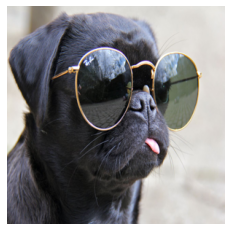

In [275]:
# Load the image
im_orig = LoadImage('/content/drive/My Drive/saliency/pug_with_glasses.png')
im_tensor = PreprocessImages([im_orig])
# Show the image
ShowImage(im_orig)

predictions = model(im_tensor)
predictions = predictions.detach().numpy()
prediction_class = np.argmax(predictions[0])
call_model_args = {class_idx_str: prediction_class}

print("Prediction class: " + str(prediction_class))  # Should be a doberman, class idx = 236, bull_mastiff = 243
im = im_orig.astype(np.float32)

### Vanilla Gradient & SmoothGrad

In [276]:
# Construct the saliency object. This alone doesn't do anthing. (runtime: 19 secs)
gradient_saliency = saliency.GradientSaliency()

# Compute the vanilla mask and the smoothed mask.
vanilla_mask_3d = gradient_saliency.GetMask(im, call_model_function, call_model_args)
smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(im, call_model_function, call_model_args)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_mask_3d)
vanilla_mask_diverging = saliency.VisualizeImageDiverging(vanilla_mask_3d)
smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d)

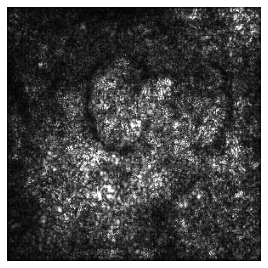

In [277]:
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(vanilla_mask_grayscale, ax=P.subplot(ROWS, COLS, 1))

In [278]:
# P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# # Render the saliency masks.
# ShowDivergingImage(vanilla_mask_diverging, ax=P.subplot(ROWS, COLS, 1))

In [279]:
# P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# # Show most salient 30% of the image
# mask = vanilla_mask_grayscale > np.percentile(vanilla_mask_grayscale, 70)
# im_mask = np.array(im_orig)
# im_mask[~mask] = 0

# ShowImage(im_mask, ax=P.subplot(ROWS, COLS, 1))

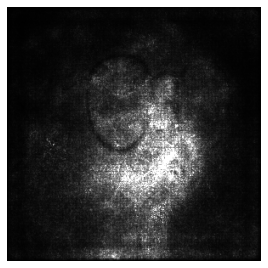

In [280]:
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(smoothgrad_mask_grayscale, ax=P.subplot(ROWS, COLS, 1))

## Integrated Gradients & SmoothGrad

For saliency methods that compute gradients along a path (e.g. Integrated Gradients), we can pass a batch_size parameter, which will batch the different steps along the path together so that the model isn't called for each individual step. When using this parameter, be sure that you are not overloading memory, as a very large batch size could crash the program.

In [281]:
# # Construct the saliency object. This alone doesn't do anthing. Takes 7,5 mins to run approximately.
# integrated_gradients = saliency.IntegratedGradients()

# # Baseline is a black image.
# baseline = np.zeros(im.shape)

# # Compute the vanilla mask and the smoothed mask.
# vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(
#   im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20)
# # Smoothed mask for integrated gradients will take a while since we are doing nsamples * nsamples computations.
# smoothgrad_integrated_gradients_mask_3d = integrated_gradients.GetSmoothedMask(
#   im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20)

# # Call the visualization methods to convert the 3D tensors to 2D grayscale.
# vanilla_ig_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_integrated_gradients_mask_3d)
# smoothgrad_ig_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_integrated_gradients_mask_3d)

In [282]:
# P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# # Render the saliency masks.
# ShowGrayscaleImage(vanilla_ig_mask_grayscale, ax=P.subplot(ROWS, COLS, 1))

In [283]:
# P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# # Render the saliency masks.
# ShowGrayscaleImage(smoothgrad_ig_mask_grayscale, ax=P.subplot(ROWS, COLS, 1))

In [284]:
# Construct the saliency object. This alone doesn't do anthing. Takes 2,5 mins to run approximately.
xrai_object = saliency.XRAI()

# Compute XRAI attributions with default parameters
xrai_attributions = xrai_object.GetMask(im, call_model_function, call_model_args, batch_size=20)

In [285]:
# P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# # Show original image
# ShowImage(im_orig, title='', ax=P.subplot(ROWS, COLS, 1))

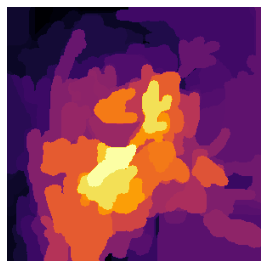

In [286]:
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Show XRAI heatmap attributions
ShowHeatMap(xrai_attributions, title='', ax=P.subplot(ROWS, COLS, 1))

In [287]:
# P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# # Show most salient 30% of the image
# mask = xrai_attributions > np.percentile(xrai_attributions, 70)
# im_mask = np.array(im_orig)
# im_mask[~mask] = 0

# ShowImage(im_mask, title='', ax=P.subplot(ROWS, COLS, 1))

### Grad-CAM

In [288]:
# Compare Grad-CAM and Smoothgrad with Grad-CAM.

# Construct the saliency object. This alone doesn't do anthing.
grad_cam = saliency.GradCam()

# Compute the Grad-CAM mask and Smoothgrad+Grad-CAM mask.
grad_cam_mask_3d = grad_cam.GetMask(im, call_model_function, call_model_args)
smooth_grad_cam_mask_3d = grad_cam.GetSmoothedMask(im, call_model_function, call_model_args)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
grad_cam_mask_grayscale = saliency.VisualizeImageGrayscale(grad_cam_mask_3d)
smooth_grad_cam_mask_grayscale = saliency.VisualizeImageGrayscale(smooth_grad_cam_mask_3d)

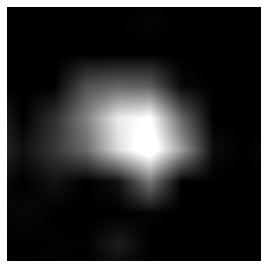

In [289]:
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(grad_cam_mask_grayscale, ax=P.subplot(ROWS, COLS, 1))

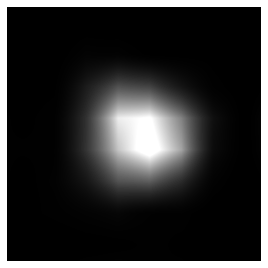

In [290]:
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(smooth_grad_cam_mask_grayscale, ax=P.subplot(ROWS, COLS, 1))

### Guided IG

In [291]:
# # Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
# # integrated_gradients = saliency.IntegratedGradients()
# guided_ig = saliency.GuidedIG()

# # Baseline is a black image for vanilla integrated gradients.
# baseline = np.zeros(im.shape)

# # Compute the vanilla mask and the Guided IG mask.
# # vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(
#   # im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20)
# guided_ig_mask_3d = guided_ig.GetMask(
#   im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, max_dist=1.0, fraction=0.5)

# # Call the visualization methods to convert the 3D tensors to 2D grayscale.
# # vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_integrated_gradients_mask_3d)
# guided_ig_mask_grayscale = saliency.VisualizeImageGrayscale(guided_ig_mask_3d)

In [292]:
# P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# # Render the saliency masks.
# ShowGrayscaleImage(guided_ig_mask_grayscale, title='', ax=P.subplot(ROWS, COLS, 1))

### Blur IG

In [293]:
# Construct the saliency object. This alone doesn't do anthing. Takes 1,5 mins to run approximately.
# integrated_gradients = saliency.IntegratedGradients()
blur_ig = saliency.BlurIG()

# Baseline is a black image for vanilla integrated gradients.
baseline = np.zeros(im.shape)

# Compute the vanilla mask and the Blur IG mask.
# vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(
  # im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20)
blur_ig_mask_3d = blur_ig.GetMask(
  im, call_model_function, call_model_args, batch_size=20)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
# vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_integrated_gradients_mask_3d)
blur_ig_mask_grayscale = saliency.VisualizeImageGrayscale(blur_ig_mask_3d)

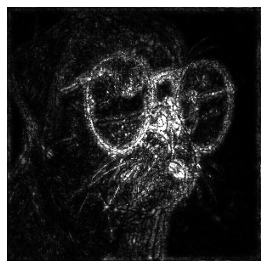

In [294]:
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(blur_ig_mask_grayscale, ax=P.subplot(ROWS, COLS, 1))

In [295]:
# # Compare BlurIG and Smoothgrad with BlurIG. Note: This will take a long time (17 mins approximately) to run.

# # Construct the saliency object. This alone doesn't do anthing.
# blur_ig = saliency.BlurIG()

# # Compute the Blur IG mask and Smoothgrad+BlurIG mask.
# # blur_ig_mask_3d = blur_ig.GetMask(im, call_model_function, call_model_args, batch_size=20)
# # Smoothed mask for BlurIG will take a while since we are doing nsamples * nsamples computations.
# smooth_blur_ig_mask_3d = blur_ig.GetSmoothedMask(im, call_model_function, call_model_args, batch_size=20)

# # Call the visualization methods to convert the 3D tensors to 2D grayscale.
# # blur_ig_mask_grayscale = saliency.VisualizeImageGrayscale(blur_ig_mask_3d)
# smooth_blur_ig_mask_grayscale = saliency.VisualizeImageGrayscale(smooth_blur_ig_mask_3d)

In [296]:
# P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# # Render the saliency masks.
# ShowGrayscaleImage(smooth_blur_ig_mask_grayscale, title='', ax=P.subplot(ROWS, COLS, 1))

In [297]:
saliency_maps = [vanilla_mask_grayscale, smoothgrad_mask_grayscale, xrai_attributions, grad_cam_mask_grayscale, blur_ig_mask_grayscale, smooth_grad_cam_mask_grayscale]

**Deletion and Insertion**

In [298]:
klen = 11
ksig = 5
kern = gkern(klen, ksig)

# Function that blurs input image
blur = lambda x: nn.functional.conv2d(x, kern, padding=klen//2)

In [299]:
model = models.inception_v3(pretrained=True, init_weights=False)
model = nn.Sequential(model, nn.Softmax(dim=1))
model = model.eval()
model = model.cuda()

for p in model.parameters():
    p.requires_grad = False
    
# To use multiple GPUs
model = nn.DataParallel(model)

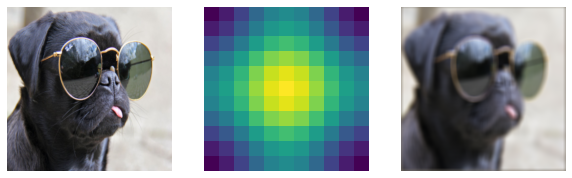

In [300]:
plt.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

plt.subplot(131)
plt.axis('off')
img = read_tensor('/content/drive/My Drive/saliency/pug_with_glasses.png')
tensor_imshow(img[0])

plt.subplot(132)
plt.axis('off')
plt.imshow(kern[0, 0])

plt.subplot(133)
plt.axis('off')
tensor_imshow(blur(img)[0])
plt.show()

In [301]:
insertion = CausalMetric(model, 'ins', 299, substrate_fn=blur)
deletion = CausalMetric(model, 'del', 299, substrate_fn=torch.zeros_like)

In [302]:
# img = read_tensor('/content/drive/My Drive/saliency/doberman.png')

# doberman_vanilla = LoadImage("doberman_vanilla.png")
# doberman_smoothgrad = LoadImage("doberman_smoothgrad.png")
# doberman_xrai = LoadImage("doberman_xrai.png")
# doberman_gradcam = LoadImage("doberman_gradcam.png")
# doberman_gradcam_smoothed = LoadImage("doberman_gradcam_smoothed.png")
# doberman_blurIG = LoadImage("doberman_blurIG.png")
# doberman_blurIG_smoothed = LoadImage("doberman_blurIG_smoothed.png")

# saliency_maps = [doberman_vanilla, doberman_smoothgrad, doberman_xrai, doberman_gradcam, doberman_gradcam_smoothed, doberman_blurIG, doberman_blurIG_smoothed]

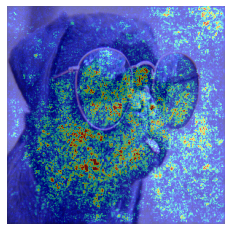

In [303]:
# 236 is for 'doberman' class
sal = saliency_maps[0] # blurIG

tensor_imshow(img[0])
plt.axis('off')
# plt.title(get_class_name(236) + " (BlurIG)")
plt.imshow(sal, cmap='jet', alpha=0.5)
plt.show()

In [304]:
deletion_list = []

for i in range(len(saliency_maps)):
  sal = saliency_maps[i]
  deletion_list.append(auc(deletion.single_run(img, sal, verbose=0)))

print(deletion_list)

deletion_list.clear()

[0.17624882301312259, 0.0661208426396255, 0.10033062714306609, 0.06219733822816301, 0.015042227027145883, 0.046716228101283674]


In [305]:
# d = deletion.single_run(img, sal, verbose=1)

In [306]:
# i = insertion.single_run(img, sal, verbose=1)

In [307]:
# d = auc(d)
# i = auc(i)
# rate = i/d
# print("AUC deletion: ", d)
# print("AUC insertion: ", i)
# print("Insertion/deletion: ", rate)

**Smoothness Metric**

In [308]:
# # Lower is smoother, which is arguably better.
# def metric_smoothness(explanation):
   
# 	laplacian = cv2.Laplacian(explanation,cv2.CV_64F)
# 	absolute_laplacian = np.absolute(laplacian)

# 	return np.average(absolute_laplacian)


# vanilla = cv2.imread("vanilla.png", cv2.IMREAD_GRAYSCALE)
# print("vanilla: " + str(metric_smoothness(vanilla)))

# smoothgrad = cv2.imread("smoothgrad.png", cv2.IMREAD_GRAYSCALE)
# print("smoothgrad: " + str(metric_smoothness(smoothgrad)))

# xrai = cv2.imread("xrai_heatmap.png", cv2.IMREAD_COLOR)
# print("xrai: " + str(metric_smoothness(xrai)))

# gradcam = cv2.imread("gradcam.png", cv2.IMREAD_GRAYSCALE)
# print("gradcam: " + str(metric_smoothness(gradcam)))

# blurIG = cv2.imread("blurIG.png", cv2.IMREAD_GRAYSCALE)
# print("blurIG: " + str(metric_smoothness(blurIG)))

# smooth_gradcam = cv2.imread("smooth_gradcam.png", cv2.IMREAD_GRAYSCALE)
# print("smooth_gradcam: " + str(metric_smoothness(smooth_gradcam)))

# smooth_blurIG = cv2.imread("smooth_blurIG.png", cv2.IMREAD_GRAYSCALE)
# print("smooth_blurIG: " + str(metric_smoothness(smooth_blurIG)))